<a href="https://colab.research.google.com/github/manabil/Applied_Machine_Learning/blob/main/(Study%20Case%20V)%20Film%20Recommendation%20System/Film%20Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Nama : Muhammad Ammar Nabil</br>
Kelas &nbsp;: M03</br>
Email &nbsp;: mammarnabil1@gmail.com

<center>

# **Movie Recommender**
###### [Zahra Nazari, Hamidreza Koohi, Javad Mousavi](https://jad.shahroodut.ac.ir/article_2390.html)
---

</center>

In this notebook, we learn how to build a recommender model to recommend a simillar film based on what they like (Content Based Filtering) or community like (Collaborative Filtering). In this model, i'll use MovieLens dataset in kaggle that includes:
* Film Title 
* Genre
* Tag
* Rating

> Number Film listed is **27262 data**

> Number ratings listed is **20.000.000 data**

</br>

## • ***Background***

I choose this problem because it's can help to improve experience of stream app company to recommend similar film that they like or community like. This is can improve satisfaction of client that can impact revenue of company.

My reference comes from **Zahra Nazari, Hamidreza Koohi, Javad Mousavi** in the journal entitled _**"Increasing Performance of Recommender Systems by Combining Deep Learning and Extreme Learning Machine"**_. In the journal, they applied new deep learning-based clustering methods in order to overcome the data sparsity problem, and increment the efficiency of the recommender systems based on precision, accuracy, F-measure, and recal. They use dataset from kaggle [MovieLens 20M Dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset). For more details about my model, download this [Details Report](https://colab.research.google.com/drive/14zROOHUuS7qmjisQAtCLewyGE_GZ5ML1?usp=sharing) <sub>Only available in Bahasa Indonesia</sub>



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from tensorflow import keras
from google.colab import files
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

## **Import and Understanding Dataset**

### *1. Data Loading*

In [ ]:
# Upload kaggle.json API
!mkdir ~/.kaggle
files.upload()
!mv kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
# Change permission
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle/ -la

total 16
drwxr-xr-x 2 root root 4096 Sep 25 16:58 .
drwx------ 1 root root 4096 Sep 25 16:58 ..
-rw------- 1 root root   63 Sep 25 16:58 kaggle.json


In [ ]:
# Download and extract kaggle dataset
!kaggle datasets download -d grouplens/movielens-20m-dataset
!unzip movielens-20m-dataset.zip
!rm movielens-20m-dataset.zip

 97% 189M/195M [00:08<00:00, 34.6MB/s]
100% 195M/195M [00:08<00:00, 24.9MB/s]
Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [ ]:
# load the dataset
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('rating.csv')

In [ ]:
print(f'Total movies \t\t= {(len(movies.title.unique()))} movie')
print(f'Total rating count \t= {(len(ratings.movieId.unique()))} rating')

Total movies 		= 27262 movie
Total rating count 	= 26744 rating


### *2. Exploratory Data Analysis - Variable Description*

#### **EDA Movies**

In [ ]:
# Check data type each atribute
print(f'Shape of movies {movies.shape}\n')
movies.info()

Shape of movies (27278, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [ ]:
# Change dataType of movieId
movies = movies.astype({'movieId': 'category', 'genres': 'category'})
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   movieId  27278 non-null  category
 1   title    27278 non-null  object  
 2   genres   27278 non-null  category
dtypes: category(2), object(1)
memory usage: 1.6+ MB


In [ ]:
# Check title attribute
print(f'Total movies : {len(movies.title.unique())} movie\n') 
movies.title.unique()

Total movies : 27262 movie



array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'The Pirates (2014)', 'Rentun Ruusu (2001)',
       'Innocence (2014)'], dtype=object)

In [ ]:
# Check genre attribute
print(f'Total genres : {len(movies.genres.unique())} genre\n') 
movies.genres.unique()

Total genres : 1342 genre



['Adventure|Animation|Children|Comedy|Fantasy', 'Adventure|Children|Fantasy', 'Comedy|Romance', 'Comedy|Drama|Romance', 'Comedy', ..., 'Adventure|Children|Drama|Sci-Fi', 'Children|Documentary|Drama', 'Action|Adventure|Animation|Fantasy|Horror', 'Animation|Children|Comedy|Fantasy|Sci-Fi', 'Animation|Children|Comedy|Western']
Length: 1342
Categories (1342, object): ['(no genres listed)', 'Action', 'Action|Adventure',
                            'Action|Adventure|Animation', ..., 'Thriller|Western', 'War', 'War|Western', 'Western']

#### **EDA Ratings**

In [ ]:
# Check data type each attribute
print(f'Shape of Ratings {ratings.shape}\n')
ratings.info()

Shape of Ratings (20000263, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [ ]:
# Change datatype to get less memory
ratings = ratings.astype({'movieId': 'category', 'userId': 'category', 
                          'rating': 'float32', 'timestamp': 'datetime64[ns]'})
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     category      
 1   movieId    category      
 2   rating     float32       
 3   timestamp  datetime64[ns]
dtypes: category(2), datetime64[ns](1), float32(1)
memory usage: 349.6 MB


In [ ]:
# Range of ratings
ratings['rating'].describe().round()

count    20000263.0
mean            4.0
std             1.0
min             0.0
25%             3.0
50%             4.0
75%             4.0
max             5.0
Name: rating, dtype: float64

In [ ]:
# Check rating attribute
print(f'Total Ratings count : {len(ratings.movieId.unique())} rating\n') 
ratings.rating.head()

Total Ratings count : 26744 rating



0    3.5
1    3.5
2    3.5
3    3.5
4    3.5
Name: rating, dtype: float32

### *3. Exploratory Data Analysis - Checking Missing Value*

In [ ]:
# Check Null value in movies
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
# Check null value in ratings
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## **Data Preprocessing**

### *1. Content Based Filtering*

In [ ]:
# Make a film only have one genre
genre_fix = movies['genres'].map(lambda genre: genre.split('|')[0])
genre_fix = pd.DataFrame(genre_fix.replace('(no genres listed)', np.nan))

# Rename genres and rename film title
genre_fix = genre_fix.replace({'genres': {'Sci-Fi': 'Scifi', 'Film-Noir': 'Noir'}})
title_fix = pd.DataFrame(movies['title'].map(lambda title: title.lower()[:-7]))

movies_fix = movies.copy()
movies_fix['film'] = title_fix
movies_fix['genre'] = genre_fix
movies_fix.drop(['title', 'genres'], 1, inplace=True)
movies_fix['genre'] = movies_fix['genre'].astype('category')
movies_fix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


,movieId,film,genre
0,1,toy story,Adventure
1,2,jumanji,Adventure
2,3,grumpier old men,Comedy
3,4,waiting to exhale,Comedy
4,5,father of the bride part ii,Comedy
...,...,...,...
27273,131254,kein bund für's leben,Comedy
27274,131256,"feuer, eis & dosenbier",Comedy
27275,131258,the pirates,Adventure
27276,131260,rentun ruusu,NaN


In [ ]:
# Drop null value
print('Before droping null value')
print(movies_fix.isna().sum(), '\n')

print('After droping null value')
movies_fix.dropna(inplace=True)
print(movies_fix.isna().sum(), '\n')
movies_fix

Before droping null value
movieId      0
film         0
genre      246
dtype: int64 

After droping null value
movieId    0
film       0
genre      0
dtype: int64 



,movieId,film,genre
0,1,toy story,Adventure
1,2,jumanji,Adventure
2,3,grumpier old men,Comedy
3,4,waiting to exhale,Comedy
4,5,father of the bride part ii,Comedy
...,...,...,...
27272,131252,forklift driver klaus: the first day on the job,Comedy
27273,131254,kein bund für's leben,Comedy
27274,131256,"feuer, eis & dosenbier",Comedy
27275,131258,the pirates,Adventure


In [ ]:
# Drop duplacate data
movies_fix.drop_duplicates('film', inplace=True)
movies_fix

,movieId,film,genre
0,1,toy story,Adventure
1,2,jumanji,Adventure
2,3,grumpier old men,Comedy
3,4,waiting to exhale,Comedy
4,5,father of the bride part ii,Comedy
...,...,...,...
27271,131250,no more school,Comedy
27272,131252,forklift driver klaus: the first day on the job,Comedy
27273,131254,kein bund für's leben,Comedy
27274,131256,"feuer, eis & dosenbier",Comedy


In [ ]:
# Create data variable
data = movies_fix.copy().rename(columns={'movieId':'id'})
data

,id,film,genre
0,1,toy story,Adventure
1,2,jumanji,Adventure
2,3,grumpier old men,Comedy
3,4,waiting to exhale,Comedy
4,5,father of the bride part ii,Comedy
...,...,...,...
27271,131250,no more school,Comedy
27272,131252,forklift driver klaus: the first day on the job,Comedy
27273,131254,kein bund für's leben,Comedy
27274,131256,"feuer, eis & dosenbier",Comedy


### *2. Collaborative Filtering*

#### **Generate movie, user to index variable**

In [ ]:
# Create rate dataset
rate_raw = ratings.copy()
rate_raw

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [ ]:
# Get unique userID
user_id = rate_raw['userId'].unique().tolist()
movie_id = rate_raw['movieId'].unique().tolist()
print('Total userID: ', len(user_id))
print('Total restoID: ', len(movie_id), '\n')
    
# Create dic user:index
user_to_index = {x: i for i, x in enumerate(user_id)}
# print('Encoded userID : ', user_to_index)
    
# Create dic index:user
index_to_user = {i: x for i, x in enumerate(user_id)}
# print('Encoded index:userID: ', index_to_user)

# Create dic movie:index
movie_to_index = {x: i for i, x in enumerate(movie_id)}
# print('Encoded movieID: ', movie_to_index)

# Create dic index:movie
index_to_movie = {i: x for i, x in enumerate(movie_id)}
# print('Encoded index:movieID: ', index_to_movie)

Total userID:  138493
Total restoID:  26744 



Mohon maaf saya tidak menampilkan hasil output diatas dikarenakan membuat crash aplikasi karena memuat data yang besar (>200000 data)

In [ ]:
# Create length of user and movie
num_user = len(user_to_index)
num_movie = len(index_to_movie)
print('Total of users = ', num_user)
print('Total of movies = ', num_movie)

Total of users =  138493
Total of movies =  26744


In [ ]:
# Add collumns user and movie based on user and movie index
rate_raw['user'] = rate_raw['userId'].map(user_to_index)
rate_raw['movie'] = rate_raw['movieId'].map(movie_to_index)

In [ ]:
rate_raw.head()

,userId,movieId,rating,timestamp,user,movie
0,1,2,3.5,2005-04-02 23:53:47,0,0
1,1,29,3.5,2005-04-02 23:31:16,0,1
2,1,32,3.5,2005-04-02 23:33:39,0,2
3,1,47,3.5,2005-04-02 23:32:07,0,3
4,1,50,3.5,2005-04-02 23:29:40,0,4


#### **Normalize**

In [ ]:
# Create min max rate_raw to normalize targed
min_rate = min(rate_raw['rating'])
max_rate = max(rate_raw['rating'])

In [ ]:
# Divide data and label then Normalize
print('Before normalize : ')

x = rate_raw[['user', 'movie']].to_numpy()
y = rate_raw["rating"].apply(lambda x: (x - min_rate) / (max_rate - min_rate)).to_numpy()

rate_raw.describe().round(2)

Before normalize : 


,rating
count,20000263.00
mean,3.53
std,1.05
min,0.50
25%,3.00
50%,3.50
75%,4.00
max,5.00


In [ ]:
# After Normalize
pd.DataFrame(y).describe().round(1)

,0
count,20000263.0
mean,0.7
std,0.2
min,0.0
25%,0.6
50%,0.7
75%,0.8
max,1.0


In [ ]:
# Change x dtype to get less memory
x = x.astype('int32')
x.dtype

dtype('int32')

In [ ]:
# Change y dtype to get less memory
y = y.astype('float16')
y.dtype

dtype('float16')

#### **Split Dataset**

In [ ]:
# Split train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.001, 
                                                    random_state = 123)

In [ ]:
# Check total of test and train set
print(f'Total # of sample in whole dataset: {len(x)}')
print(f'Total # of sample in train dataset: {len(x_train)}')
print(f'Total # of sample in test dataset: {len(x_test)}')

Total # of sample in whole dataset: 20000263
Total # of sample in train dataset: 19980262
Total # of sample in test dataset: 20001


## **Model Development**

### *1. Content Based Filtering*

In [ ]:
data.genre.unique()

['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', ..., 'Romance', 'War', 'Scifi', 'Musical', 'IMAX']
Length: 19
Categories (19, object): ['Action', 'Adventure', 'Animation', 'Children', ..., 'Scifi', 'Thriller',
                          'War', 'Western']

In [ ]:
# Vectorize data with TF-IDF
tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(data['genre']) 

print('Shape of TF-IDF Matrix =', tfidf_matrix.shape, '\n')
tf.get_feature_names_out()

Shape of TF-IDF Matrix = (25966, 19) 



array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'horror', 'imax', 'musical',
       'mystery', 'noir', 'romance', 'scifi', 'thriller', 'war',
       'western'], dtype=object)

In [ ]:
# Dense TF-IDF Matrix
tfidf_matrix.todense()

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
# Calculate cosine similarity of tfidf_matrix
cosine_matrix= cosine_similarity(tfidf_matrix) 
cosine_matrix

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.]])

In [ ]:
# Create cosine similary dataframe with film
cosine_df = pd.DataFrame(cosine_matrix, index=data['film'], columns=data['film'])
print('Shape:', cosine_df.shape)
    
cosine_df.head()

Shape: (25966, 25966)


film,toy story,jumanji,grumpier old men,waiting to exhale,father of the bride part ii,heat,sabrina,tom and huck,sudden death,goldeneye,...,what men talk about,three quarter moon,ants in the pants,werner - gekotzt wird später,brother bear 2,no more school,forklift driver klaus: the first day on the job,kein bund für's leben,"feuer, eis & dosenbier",the pirates
film,,,,,,,,,,,,,,,,,,,,,
toy story,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
jumanji,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
grumpier old men,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
waiting to exhale,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
father of the bride part ii,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0


### *2. Collaborate Filtering*

In [ ]:
# Modify RecommenderNet Class
class RecommenderNet(tf.keras.Model):
    
    # Define Constructor
    def __init__(self, num_users, num_movie, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movie = num_movie
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding( num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1) 
        self.resto_embedding = layers.Embedding( 
            num_movie,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.resto_bias = layers.Embedding(num_movie, 1)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0]) 
        user_bias = self.user_bias(inputs[:, 0]) 
        resto_vector = self.resto_embedding(inputs[:, 1]) 
        resto_bias = self.resto_bias(inputs[:, 1]) 
        
        dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
        
        x = dot_user_resto + user_bias + resto_bias
        
        return tf.nn.sigmoid(x) 

In [ ]:
# Create Model
model = RecommenderNet(num_user, num_movie, 50)
model.compile('Adam', 'binary_crossentropy', 
              [tf.keras.metrics.MeanSquaredError()])

In [ ]:
# Create Callback
callback= [
    EarlyStopping('val_mean_squared_error', 0.1, 8, 1),
]

In [ ]:
# Train Model
history = model.fit(
    x_train, 
    y_train, 
    200000, 
    50, 
    callbacks=callback,
    validation_data = (x_test, y_test)
)

Epoch 1/50
100/100 [==============================] - 29s 265ms/step - loss: 0.6538 - mean_squared_error: 0.0639 - val_loss: 0.6472 - val_mean_squared_error: 0.0611
Epoch 2/50
100/100 [==============================] - 27s 267ms/step - loss: 1.4197 - mean_squared_error: 0.1478 - val_loss: 0.8099 - val_mean_squared_error: 0.1398
Epoch 3/50
100/100 [==============================] - 33s 331ms/step - loss: 6.1476 - mean_squared_error: 0.2614 - val_loss: 1.3699 - val_mean_squared_error: 0.1526
Epoch 4/50
100/100 [==============================] - 26s 262ms/step - loss: 6.5779 - mean_squared_error: 0.1901 - val_loss: 2.0804 - val_mean_squared_error: 0.4447
Epoch 5/50
100/100 [==============================] - 26s 258ms/step - loss: 4.5104 - mean_squared_error: 0.2610 - val_loss: 0.8934 - val_mean_squared_error: 0.1162
Epoch 6/50
100/100 [==============================] - 27s 266ms/step - loss: 4.1191 - mean_squared_error: 0.1977 - val_loss: 2.6865 - val_mean_squared_error: 0.4805
Epoch 7/50

## **Model Evaluation**

### *1. Content Based Filtering*

Sebelum menjalankan code dibawah, jalankan terlebih dahulu testing Content Based Filtering di cell terakhir

In [ ]:
# Check genre of toy story
genre_target = data[data.film.eq('toy story')]['genre'][0]
genre_target

'Adventure'

In [ ]:
# Get recommendations
num_recommendation = 15

result = film_recommendations('toy story', num_recommendation)
num_correct = result[result.genre == genre_target].genre.count()
pred_score = (num_correct / num_recommendation)*100
num_all_genre_target = data[data.genre == genre_target].genre.count()
recall_score = (num_correct / num_all_genre_target)*100


print(f'Precission of model is : {int(pred_score)} %')
print(f'Recall of model is : {recall_score} ')

Precission of model is : 100 %
Recall of model is : 1.1727912431587177 


In [ ]:
film_recommendations('toy story', num_recommendation)

,film,genre
0,The Pirates,Adventure
1,Toy Story 3,Adventure
2,"Descent: Part 2, The",Adventure
3,The Black Rose,Adventure
4,Young Winston,Adventure
5,St Trinian'S 2: The Legend Of Fritton'S Gold,Adventure
6,"Sky Crawlers, The (Sukai Kurora)",Adventure
7,Shrek Forever After (A.K.A. Shrek: The Final C...,Adventure
8,Percy Jackson & The Olympians: The Lightning T...,Adventure
9,B.N.B. (Bunty Aur Babli),Adventure


### *2. Collaborative Filtering*

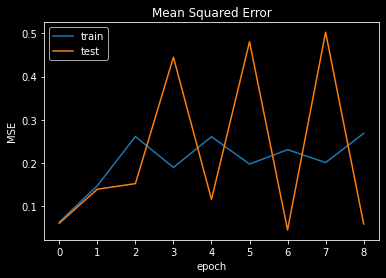

In [ ]:
plt.style.use('dark_background')

plt.plot(history.history['mean_squared_error'], '#1f77b4')
plt.plot(history.history['val_mean_squared_error'], '#ff7f0e')
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Testing**

### *1. Content Based Filtering*

In [ ]:
# Create recommendations function
def film_recommendations(film: str, 
                         n: int=5,
                         similarity_data: pd.DataFrame=cosine_df, 
                         items: pd.DataFrame=data[['film', 'genre']]):
    """
    Recommends top N-Recommendation of similar film based on genre.
    
    Parameter:
    ---
    film : string (str)
           A Film that will be a reference for recommendations.
    similarity_data : pd.DataFrame (object)
                      Dataframe similarity, symmetric, resto as a index and 
                      collumns
    items : pd.DataFrame (object)
            Dataframe of film info
    k : integer (int)
        Total of return recommendations

    Returns
    ---
    Returns a dataframe of top N-Recommendation.
    """

    # Locate similarity restaurant
    index = similarity_data.loc[:,film.lower()].to_numpy().argpartition(
        range(-1, -n, -1))
    
    # Sort closest similarity
    closest = similarity_data.columns[index[-1:-(n+2):-1]]
    
    # Drop unused data restaurant
    closest = closest.drop(film.lower(), errors='ignore')

    result = pd.DataFrame(closest).merge(items).head(n)
    film_fix = result['film'].map(lambda title: title.title())
    result['film'] = film_fix
    
    return result

In [ ]:
# Check genre of toy story
data[data.film.eq('toy story')]

,id,film,genre
0,1,toy story,Adventure


In [ ]:
# Get recommendations
film_recommendations('toy story', 15)

,film,genre
0,The Pirates,Adventure
1,Toy Story 3,Adventure
2,"Descent: Part 2, The",Adventure
3,The Black Rose,Adventure
4,Young Winston,Adventure
5,St Trinian'S 2: The Legend Of Fritton'S Gold,Adventure
6,"Sky Crawlers, The (Sukai Kurora)",Adventure
7,Shrek Forever After (A.K.A. Shrek: The Final C...,Adventure
8,Percy Jackson & The Olympians: The Lightning T...,Adventure
9,B.N.B. (Bunty Aur Babli),Adventure


### *2. Collaborate Filtering*

In [ ]:
dataset = data.copy()

In [ ]:
def highRatedMovie(user: int=user_id, 
                   n: int=5,
                   data_raw: pd.DataFrame=dataset, 
                   data_rate: pd.DataFrame=ratings):
    '''
    Show N-High Rated Movie from user

    Parameter
    ---
    user: int
          Id of user. Must member of dataset.
    n: int
       Total returns of high rate movies. Default 5
    data_raw: pd.DataFrame=dataset
              Dataset of movies. Must contain movieId and genres. Default
              dataset
    data_rate: pd.DataFrame
               Dataset of rating. Must contain rating, movieId, and userId.
               Default ratings

    Return
    ---
    Prompt of N-High Rated Movie from user
    '''
    # Prompt Result
    print('===' * 13)
    print(f'Movie with high ratings from user {user}')
    print('===' * 13)

    watched_movie_by_user = data_rate[ratings.userId == user]
    top_movie_user = (watched_movie_by_user.sort_values(
            by = 'rating',
            ascending=False
        )
        .head(n)
        .movieId.values
    )
        
    dataset_rows = data_raw[data_raw['id'].isin(top_movie_user)]
    for row in dataset_rows.itertuples():
        print(f'    •', (row.film).title(), ':', row.genre)

In [ ]:
highRatedMovie(546,10)

Movie with high ratings from user 546
    • Dr. Strangelove Or: How I Learned To Stop Worrying And Love The Bomb : Comedy
    • Godfather, The : Crime
    • William Shakespeare'S Romeo + Juliet : Drama
    • Reservoir Dogs : Crime
    • Ice Storm, The : Drama
    • American Beauty : Comedy
    • Ghost Dog: The Way Of The Samurai : Crime
    • City Of God (Cidade De Deus) : Action
    • Lost In Translation : Comedy
    • Garden State : Comedy


In [ ]:
def movieRecommendation(user: int=user_id, 
                        n: int=5,
                        data_raw: pd.DataFrame=dataset,
                        data_rate: pd.DataFrame=ratings,
                        movieIdx: dict=movie_to_index,
                        userIdx: dict=user_to_index):
    '''
    Show N-Recommendation of Movie from user

    Parameter
    ---
    user: int
          Id of user. Must member of dataset.
    n: int
       Total returns of high rate movies. Default 5
    data_raw: pd.DataFrame=dataset
              Dataset of movies. Must contain movieId and genres. Default
              dataset
    data_rate: pd.DataFrame
               Dataset of rating. Must contain rating, movieId, and userId.
               Default ratings
    movieIdx: dict
              Movie to movie encode (index) dataframe. Default movie_to_index
    userIdx: dict
             User to user encode (index) dataframe. Default user_to_index

    Return
    ---
    Prompt of N-Recommendation of Movie from user
    '''
    # Filter not visited movie
    watched_movie_by_user = data_rate[data_rate.userId == user]
    
    movie_not_watched = data_raw[~data_raw['id'].isin(watched_movie_by_user.movieId.values)]['id'] 
    movie_not_watched = list(
        set(movie_not_watched)
        .intersection(set(movieIdx.keys()))
    )
    movie_not_watched = [[movieIdx.get(x)] for x in movie_not_watched]

    user_encoder = userIdx.get(user)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
    )
    recommendation = model.predict(user_movie_array).flatten()
    top_ratings_indices = recommendation.argsort()[-n:][::-1]

    recommended_movie_ids = [
        index_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
    ]
    
    # Prompt result
    print('====' * 11)
    print(f'Top {n} movie recommendation for user {user}')
    print('====' * 11)
        
    recommended_resto = data_raw[data_raw['id'].isin(recommended_movie_ids)]
    for row in recommended_resto.itertuples():
        print(f'    •', (row.film).title(), ':', row.genre)

In [ ]:
movieRecommendation(546, 10)

Top 10 movie recommendation for user 546
    • Vertigo : Drama
    • Rear Window : Mystery
    • It Happened One Night : Comedy
    • Sunset Blvd. (A.K.A. Sunset Boulevard) : Drama
    • 12 Angry Men : Drama
    • Best Years Of Our Lives, The : Drama
    • On The Waterfront : Crime
    • 400 Blows, The (Les Quatre Cents Coups) : Crime
    • Rashomon (Rashômon) : Crime
    • Secret In Their Eyes, The (El Secreto De Sus Ojos) : Crime
